In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import date
import seaborn as sns

In [79]:
# vacc_url = 'https://opendata.arcgis.com/datasets/f23a050f72774954a91263f77031dfa3_0.csv'
vacc_url = 'https://alaska-dhss.maps.arcgis.com/home/item.html?id=72a950ab271c492d95a159806f3fa28d/data'
df = pd.read_csv(vacc_url, parse_dates=['ADMIN_DATE'])
# df['ADMIN_DATE'] = df['ADMIN_DATE'].dt.tz_localize(None)
# df.to_csv('../data/raw/vaccines.csv', index=False)

ValueError: Missing column provided to 'parse_dates': 'ADMIN_DATE'

In [75]:
df.columns

Index(['ADMIN_DATE', 'MVX', 'DOSE_NUM', 'VAX_SERIES_COMPLETE', 'REGION_NUM',
       'BEHAVIORAL_REGION', 'BOROUGH_FIPS', 'BOROUGH_NAME', 'ADJ_BOROUGH_FIPS',
       'ADJ_BOROUGH_NAME', 'RECIP_RESIDENT_IND', 'Unique_Count', 'DATA_DT',
       'FID'],
      dtype='object')

In [37]:
df = df.dropna(thresh=5).copy()

In [38]:
bad_dates = {}

for group_name, df_group in df[df['ADMIN_DATE']<'15 DEC 2020'].groupby('MVX'):
    bad_dates[group_name] = len(df_group)

df = df[df['ADMIN_DATE']>='15 DEC 2020'].copy()

In [39]:
bad_dates

{'PFR': 4}

In [40]:
df = df[df['DOSE_NUM']<2].copy()

In [41]:
df['ADMIN_DATE'] = pd.to_datetime(df['ADMIN_DATE']).dt.date

In [42]:
df.tail()

,ADMIN_DATE,MVX,DOSE_NUM,VAX_SERIES_COMPLETE,REGION_NUM,BEHAVIORAL_REGION,BOROUGH_FIPS,BOROUGH_NAME,ADJ_BOROUGH_FIPS,ADJ_BOROUGH_NAME,RECIP_RESIDENT_IND,Unique_Count,DATA_DT,FID
14014,2021-05-20,MOD,1,NO,7,Other Interior Region,290,Yukon-Koyukuk Census Area,290,Yukon-Koyukuk Census Area,0,4,2021/05/21 00:00:00+00,14015
14015,2021-05-20,MOD,1,NO,7,Other Interior Region,290,Yukon-Koyukuk Census Area,290,Yukon-Koyukuk Census Area,1,1,2021/05/21 00:00:00+00,14016
14017,2021-05-20,PFR,1,NO,6,Northwest Region,188,Northwest Arctic Borough,188,Northwest Arctic Borough,1,2,2021/05/21 00:00:00+00,14018
14018,2021-05-20,PFR,1,NO,7,Other Interior Region,68,Denali Borough,68,Denali Borough,1,10,2021/05/21 00:00:00+00,14019
14019,2021-05-20,PFR,1,UNK,1,Anchorage Region,20,Anchorage Municipality,20,Anchorage Municipality,1,1,2021/05/21 00:00:00+00,14020


In [43]:
df_vacc = pd.pivot_table(df, values='Unique_Count', index='ADMIN_DATE', columns='MVX', aggfunc='sum')

In [44]:
df_vacc = df_vacc.fillna(0)

In [45]:
df_vacc.head()

MVX,JSN,MOD,OTH,PFR,UNK
ADMIN_DATE,,,,,
2020-12-15,0.0,1.0,0.0,127.0,0.0
2020-12-16,0.0,0.0,0.0,1179.0,0.0
2020-12-17,0.0,0.0,0.0,2303.0,0.0
2020-12-18,0.0,0.0,0.0,3108.0,0.0
2020-12-19,0.0,0.0,0.0,883.0,0.0


In [46]:
cols = df_vacc.columns
df_vacc['total'] = df_vacc[cols].sum(axis=1)

In [47]:
df_vacc.to_csv('../data/parsed/vaccines.csv', index=True)
last_date = df_vacc.index[-5]
# last_date = pd.to_datetime('26 FEB 2021')
df_vacc['cumulative_total'] = df_vacc['total'].cumsum()
total_first_dose = df_vacc['cumulative_total'][-5]
df_vacc.tail(10)

MVX,JSN,MOD,OTH,PFR,UNK,total,cumulative_total
ADMIN_DATE,,,,,,,
2021-05-11,227.0,211.0,0.0,474.0,0.0,912.0,306746.0
2021-05-12,189.0,284.0,0.0,261.0,0.0,734.0,307480.0
2021-05-13,162.0,204.0,0.0,560.0,0.0,926.0,308406.0
2021-05-14,349.0,322.0,1.0,740.0,0.0,1412.0,309818.0
2021-05-15,163.0,101.0,0.0,331.0,0.0,595.0,310413.0
2021-05-16,47.0,57.0,0.0,153.0,0.0,257.0,310670.0
2021-05-17,194.0,218.0,1.0,415.0,0.0,828.0,311498.0
2021-05-18,209.0,195.0,0.0,373.0,1.0,778.0,312276.0
2021-05-19,170.0,241.0,1.0,373.0,0.0,785.0,313061.0


In [48]:
df_vacc['JSN'].sum()

19528.0

## Build Models

In [49]:
from fbprophet import Prophet

In [50]:
m_pfr = Prophet(growth='logistic')
m_mod = Prophet(growth='logistic')
m_tot = Prophet(growth='logistic')

In [51]:
df_pfr = df_vacc[df_vacc.index<last_date].reset_index()[['ADMIN_DATE', 'PFR']]
df_pfr.columns = ['ds', 'y']
df_pfr['cap']=10E3
df_pfr['floor']=0

df_mod = df_vacc[df_vacc.index<last_date].reset_index()[['ADMIN_DATE', 'MOD']]
df_mod.columns = ['ds', 'y']
df_mod['cap']=10E3
df_mod['floor']=0

df_tot = df_vacc[df_vacc.index<last_date].reset_index()[['ADMIN_DATE', 'total']]
df_tot.columns = ['ds', 'y']
df_tot['cap']=10E3
df_tot['floor']=0

In [52]:
m_pfr.fit(df_pfr)
m_mod.fit(df_mod)
m_tot.fit(df_tot)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [53]:
future_pfr = m_pfr.make_future_dataframe(periods=60)
future_pfr['cap'] =10E3
future_pfr['floor'] = 0
future_pfr.tail()

future_mod = m_mod.make_future_dataframe(periods=60)
future_mod['cap'] =10E3
future_mod['floor'] = 0
future_mod.tail()

future_tot = m_tot.make_future_dataframe(periods=60)
future_tot['cap'] =10E3
future_tot['floor'] = 0
future_tot.tail()

,ds,cap,floor
206,2021-07-10,10000.0,0
207,2021-07-11,10000.0,0
208,2021-07-12,10000.0,0
209,2021-07-13,10000.0,0
210,2021-07-14,10000.0,0


In [54]:
forecast_pfr = m_pfr.predict(future_pfr)
forecast_pfr[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

forecast_mod = m_mod.predict(future_mod)
forecast_mod[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

forecast_tot = m_tot.predict(future_tot)
forecast_tot[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
206,2021-07-10,1745.214417,164.965336,3482.085146
207,2021-07-11,565.901609,-1065.099818,2345.511090
208,2021-07-12,1593.439317,-184.222454,3159.424961
209,2021-07-13,2519.057895,824.677663,4269.207984
210,2021-07-14,2481.650783,785.099426,4232.347509


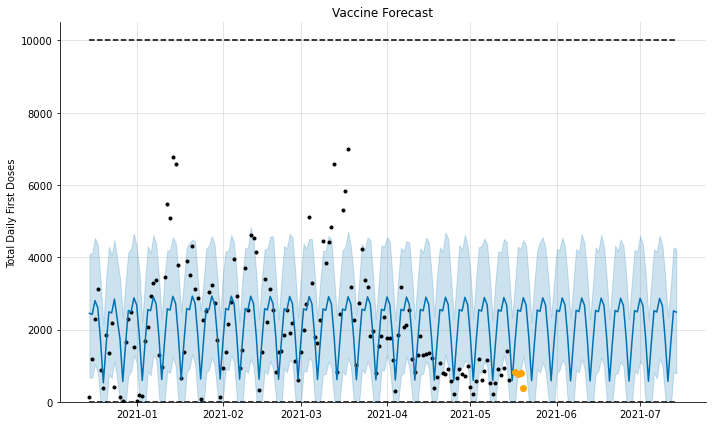

In [55]:
# check the accuracy of the forecast graphically

fig1 = m_tot.plot(forecast_tot)
plt.plot(df_vacc[last_date<df_vacc.index].index, df_vacc[last_date<df_vacc.index]['total'], color='orange', marker='o', ls='')
plt.title('Vaccine Forecast')
plt.ylabel('Total Daily First Doses')
plt.xlabel('')
plt.ylim(0,10500)
sns.despine();

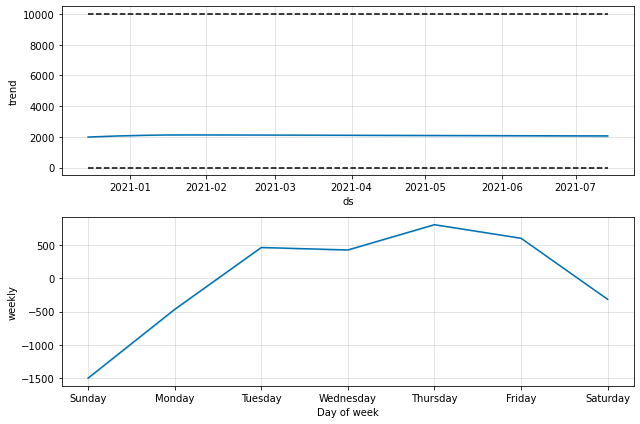

In [56]:
fig2 = m_tot.plot_components(forecast_tot)

Text(0.5, 33.0, '')

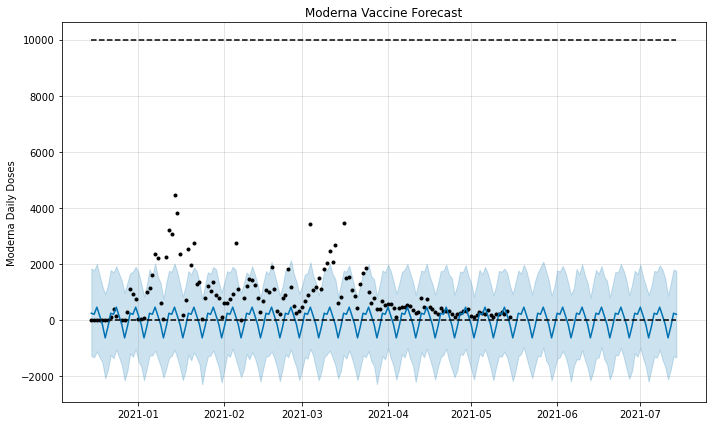

In [57]:
fig1 = m_mod.plot(forecast_mod)
plt.title('Moderna Vaccine Forecast')
plt.ylabel('Moderna Daily Doses')
plt.xlabel('')

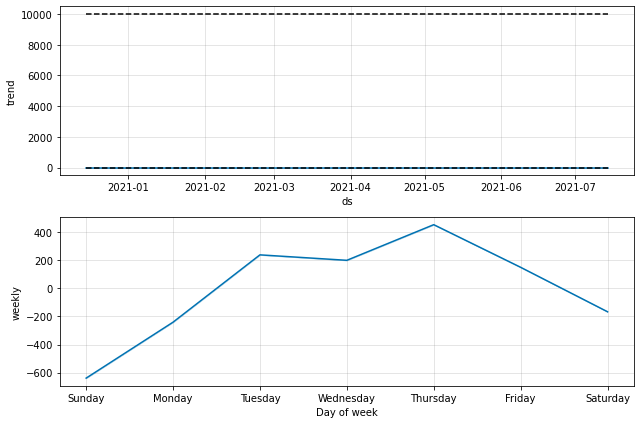

In [58]:
fig2 = m_mod.plot_components(forecast_mod)

Text(0.5, 33.0, '')

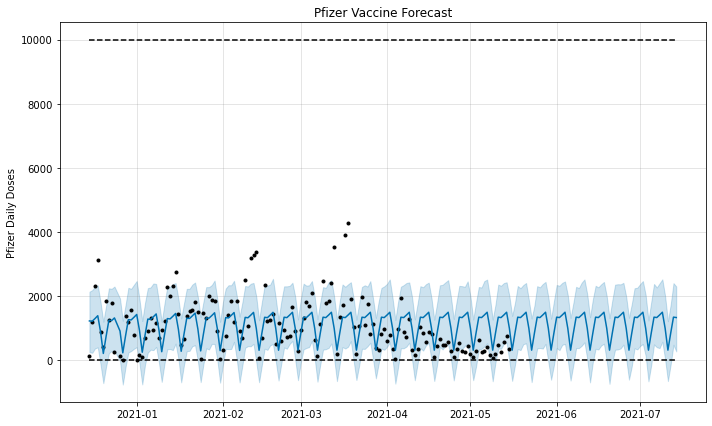

In [59]:
fig1 = m_pfr.plot(forecast_pfr)
plt.title('Pfizer Vaccine Forecast')
plt.ylabel('Pfizer Daily Doses')
plt.xlabel('')

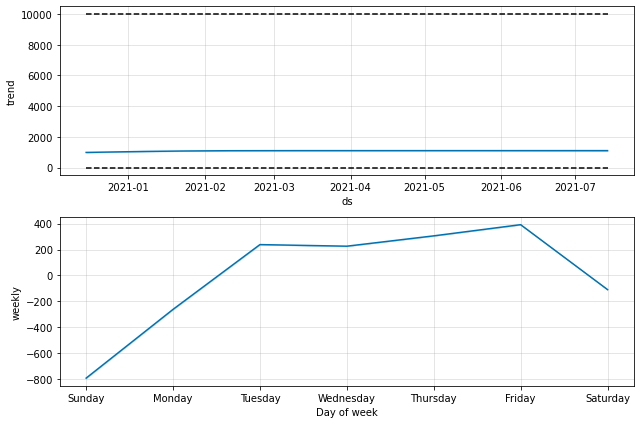

In [60]:
fig2 = m_pfr.plot_components(forecast_pfr)

## Check Cumulative First Doses

In [61]:
df_forecast = forecast_tot[forecast_tot['ds'].dt.date>last_date].copy()

In [62]:
df_forecast['yhat'] = round(df_forecast['yhat'],0)
df_forecast['cumulative_yhat'] = df_forecast['yhat'].cumsum()
df_forecast['cumulative_yhat'] = df_forecast['cumulative_yhat']+total_first_dose

In [63]:
total_ak_pop = 585E3
total_ak_pop*0.50

292500.0

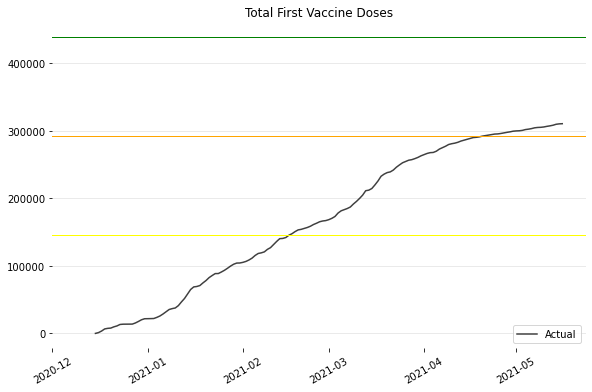

In [64]:
fig, ax = plt.subplots(figsize=(600/72,400/72))
ax.set_title('Total First Vaccine Doses')
ax.plot(df_vacc[df_vacc.index<=last_date].index, df_vacc[df_vacc.index<=last_date]['cumulative_total'], c='black', label='Actual', linestyle='-', zorder=1, alpha=.75)
# ax.plot(df_forecast['ds'], df_forecast['cumulative_yhat'], c='blue', label='Forecasted', linestyle='-', zorder=1, alpha=.75)
ax.legend()
plt.axhline(total_ak_pop*0.25, color='yellow', linewidth=1)

plt.axhline(total_ak_pop*0.50, color='orange', linewidth=1)

plt.axhline(total_ak_pop*0.75, color='green', linewidth=1)

ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.autofmt_xdate(ha='center', )

x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,y1,y2))

ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
ax.set_xlim(pd.Timestamp('2020-12-01'),)


fig.set_facecolor('w')

fig.tight_layout()

In [65]:
df_vacc.tail(25)

MVX,JSN,MOD,OTH,PFR,UNK,total,cumulative_total
ADMIN_DATE,,,,,,,
2021-04-26,73.0,225.0,0.0,355.0,0.0,653.0,296188.0
2021-04-27,117.0,263.0,0.0,530.0,0.0,910.0,297098.0
2021-04-28,180.0,317.0,0.0,271.0,0.0,768.0,297866.0
2021-04-29,140.0,326.0,0.0,258.0,0.0,724.0,298590.0
2021-04-30,171.0,377.0,0.0,446.0,0.0,994.0,299584.0
2021-05-01,81.0,132.0,0.0,191.0,0.0,404.0,299988.0
2021-05-02,35.0,89.0,0.0,82.0,0.0,206.0,300194.0
2021-05-03,117.0,178.0,0.0,282.0,0.0,577.0,300771.0
2021-05-04,300.0,281.0,0.0,615.0,0.0,1196.0,301967.0


In [66]:
df_forecast.head(50)

,ds,trend,cap,floor,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,cumulative_yhat
152,2021-05-17,2083.004688,10000.0,0,-66.649733,3233.715403,2082.928222,2083.077422,-467.120610,-467.120610,-467.120610,-467.120610,-467.120610,-467.120610,0.0,0.0,0.0,1616.0,312286.0
153,2021-05-18,2082.602314,10000.0,0,868.148240,4295.011695,2082.282916,2082.887639,458.897134,458.897134,458.897134,458.897134,458.897134,458.897134,0.0,0.0,0.0,2541.0,314827.0
154,2021-05-19,2082.199997,10000.0,0,793.057427,4221.316247,2081.592617,2082.694942,421.889132,421.889132,421.889132,421.889132,421.889132,421.889132,0.0,0.0,0.0,2504.0,317331.0
155,2021-05-20,2081.797737,10000.0,0,1259.036751,4471.566180,2080.838916,2082.623599,800.101521,800.101521,800.101521,800.101521,800.101521,800.101521,0.0,0.0,0.0,2882.0,320213.0
156,2021-05-21,2081.395534,10000.0,0,820.984231,4332.796577,2080.086633,2082.510218,597.434383,597.434383,597.434383,597.434383,597.434383,597.434383,0.0,0.0,0.0,2679.0,322892.0
157,2021-05-22,2080.993389,10000.0,0,62.851081,3328.784588,2079.248263,2082.429791,-316.144016,-316.144016,-316.144016,-316.144016,-316.144016,-316.144016,0.0,0.0,0.0,1765.0,324657.0
158,2021-05-23,2080.591301,10000.0,0,-1076.631097,2209.246744,2078.433724,2082.484651,-1495.057543,-1495.057543,-1495.057543,-1495.057543,-1495.057543,-1495.057543,0.0,0.0,0.0,586.0,325243.0
159,2021-05-24,2080.189270,10000.0,0,-25.151836,3299.158034,2077.638429,2082.576537,-467.120610,-467.120610,-467.120610,-467.120610,-467.120610,-467.120610,0.0,0.0,0.0,1613.0,326856.0
160,2021-05-25,2079.787297,10000.0,0,895.220667,4181.646147,2076.642090,2082.704208,458.897134,458.897134,458.897134,458.897134,458.897134,458.897134,0.0,0.0,0.0,2539.0,329395.0
161,2021-05-26,2079.385380,10000.0,0,808.713028,4427.486701,2075.690512,2082.995011,421.889132,421.889132,421.889132,421.889132,421.889132,421.889132,0.0,0.0,0.0,2501.0,331896.0


In [67]:
forecast_tot[forecast_tot['ds'].dt.date>last_date]

,ds,trend,cap,floor,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
152,2021-05-17,2083.004688,10000.0,0,-66.649733,3233.715403,2082.928222,2083.077422,-467.120610,-467.120610,-467.120610,-467.120610,-467.120610,-467.120610,0.0,0.0,0.0,1615.884078
153,2021-05-18,2082.602314,10000.0,0,868.148240,4295.011695,2082.282916,2082.887639,458.897134,458.897134,458.897134,458.897134,458.897134,458.897134,0.0,0.0,0.0,2541.499448
154,2021-05-19,2082.199997,10000.0,0,793.057427,4221.316247,2081.592617,2082.694942,421.889132,421.889132,421.889132,421.889132,421.889132,421.889132,0.0,0.0,0.0,2504.089129
155,2021-05-20,2081.797737,10000.0,0,1259.036751,4471.566180,2080.838916,2082.623599,800.101521,800.101521,800.101521,800.101521,800.101521,800.101521,0.0,0.0,0.0,2881.899258
156,2021-05-21,2081.395534,10000.0,0,820.984231,4332.796577,2080.086633,2082.510218,597.434383,597.434383,597.434383,597.434383,597.434383,597.434383,0.0,0.0,0.0,2678.829917
157,2021-05-22,2080.993389,10000.0,0,62.851081,3328.784588,2079.248263,2082.429791,-316.144016,-316.144016,-316.144016,-316.144016,-316.144016,-316.144016,0.0,0.0,0.0,1764.849373
158,2021-05-23,2080.591301,10000.0,0,-1076.631097,2209.246744,2078.433724,2082.484651,-1495.057543,-1495.057543,-1495.057543,-1495.057543,-1495.057543,-1495.057543,0.0,0.0,0.0,585.533758
159,2021-05-24,2080.189270,10000.0,0,-25.151836,3299.158034,2077.638429,2082.576537,-467.120610,-467.120610,-467.120610,-467.120610,-467.120610,-467.120610,0.0,0.0,0.0,1613.068660
160,2021-05-25,2079.787297,10000.0,0,895.220667,4181.646147,2076.642090,2082.704208,458.897134,458.897134,458.897134,458.897134,458.897134,458.897134,0.0,0.0,0.0,2538.684431
161,2021-05-26,2079.385380,10000.0,0,808.713028,4427.486701,2075.690512,2082.995011,421.889132,421.889132,421.889132,421.889132,421.889132,421.889132,0.0,0.0,0.0,2501.274512


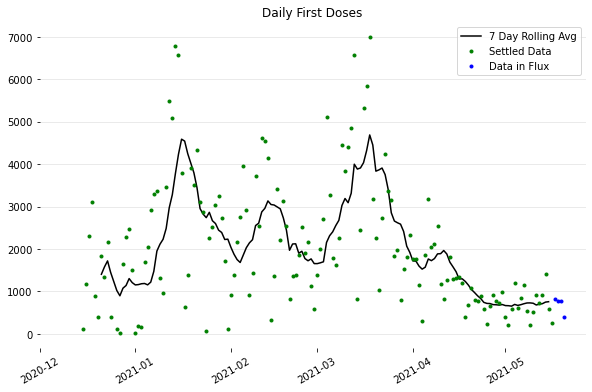

In [68]:
fig, ax = plt.subplots(figsize=(600/72,400/72))
ax.set_title('Daily First Doses')

ax.plot(df_vacc[last_date>df_vacc.index].index, df_vacc[last_date>df_vacc.index]['total'].rolling(7).mean(), 'k-', label='7 Day Rolling Avg')
ax.plot(df_vacc[last_date>=df_vacc.index].index, df_vacc[last_date>=df_vacc.index]['total'], 'g.', label='Settled Data')
ax.plot(df_vacc[last_date<df_vacc.index].index, df_vacc[last_date<df_vacc.index]['total'], 'b.', label='Data in Flux')

ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.autofmt_xdate(ha='center', )

x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,y1,y2))

ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)

   
# for key, value in vacc_dates.items():
#     plt.axvline(parse(key), color='k', linewidth=1)
#     plt.text(parse(key), y2*0.01, value, rotation=90, va='bottom', ha='right')
    
#     plt.axvline(parse('5 OCT 2020'), color='black')
ax.legend()

fig.set_facecolor('w')

ax.set_xlim(pd.Timestamp('1 DEC 2020'), date.today())
fig.tight_layout()